In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [1]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Mutual information 

def mutual_information(x,y):
    x,y = np.array(x), np.array(y)
    hist_2d, _, _ = np.histogram2d(x.ravel(), y.ravel(), bins=20)
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals

    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

## Loading the tensors

In [4]:
data = torch.load('ADNI_t1', map_location='cpu')

In [5]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 10047 visits with a total of 614400 dimentions


In [6]:
template_data_path = "/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [7]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data /= template_data.max()
template_data.shape

torch.Size([1, 80, 96, 80])

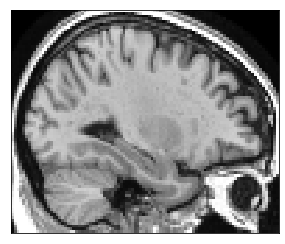

In [8]:
plt.matshow(np.rot90(data['data'][8][55]), cmap='Greys_r')
plt.xticks([])
plt.yticks([])
plt.show()

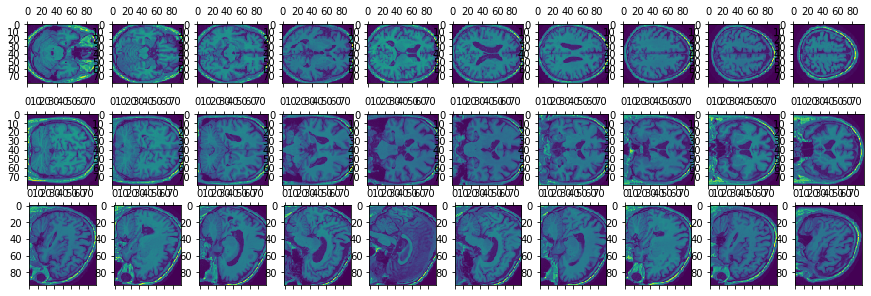

In [9]:
fig, axes = plt.subplots(3,10, figsize=(15,5))


for i in range(10):
    axes[0][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][20 + 5*i])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [10]:
caps_info = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE', 'sex', 'apoe4', 'adas13']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE sex  apoe4  adas13
participant_id   session_id                                         
sub-ADNI002S0295 ses-M00     84.8        CN  28.0   M    1.0    4.00
                 ses-M06     85.3        CN  28.0   M    1.0    6.33
                 ses-M12     85.8        CN  30.0   M    1.0    5.67
                 ses-M24     87.0        CN  29.0   M    1.0    5.67
                 ses-M36     87.8        CN  28.0   M    1.0    6.67
...                           ...       ...   ...  ..    ...     ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0   F    0.0   11.33
                 ses-M12     75.4       NaN   NaN   F    0.0     NaN
                 ses-M24     76.4       NaN  30.0   F    0.0   15.33
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0   F    NaN   32.67
sub-ADNI941S6854 ses-M00     86.2        AD  30.0   M    NaN   27.00

[16319 rows x 6 columns]

In [11]:
caps_info['ID'] = [int(sub[-4:]) for sub in caps_info.index.get_level_values(0)]
caps_info = caps_info.set_index('ID')
caps_info = caps_info.rename(columns={'age':'TIME','diagnosis':'diag'})
caps_info

TIME diag  MMSE sex  apoe4  adas13
ID                                      
295   84.8   CN  28.0   M    1.0    4.00
295   85.3   CN  28.0   M    1.0    6.33
295   85.8   CN  30.0   M    1.0    5.67
295   87.0   CN  29.0   M    1.0    5.67
295   87.8   CN  28.0   M    1.0    6.67
...    ...  ...   ...  ..    ...     ...
6581  74.4   CN  30.0   F    0.0   11.33
6581  75.4  NaN   NaN   F    0.0     NaN
6581  76.4  NaN  30.0   F    0.0   15.33
6803  75.0  MCI  28.0   F    NaN   32.67
6854  86.2   AD  30.0   M    NaN   27.00

[16319 rows x 6 columns]

In [12]:
RIDs = [int(sub) for sub in list(data['RID'])]

df = pd.DataFrame(index=RIDs)
df.index.name = 'ID'
df['labels'] = data['labels']
df['TIME'] = data['timepoints']
df['img_idx'] = np.arange(len(df))

In [13]:
df['ID'] = df.index
df = df.set_index(['ID', 'TIME'])
caps_info['ID'] = caps_info.index
caps_info = caps_info.set_index(['ID', 'TIME'])

In [14]:
df

labels  img_idx
ID   TIME                 
295  84.8       0        0
     85.3       0        1
     85.8       0        2
     87.0       0        3
     87.8       0        4
...           ...      ...
6575 74.5    2246    10042
6580 79.9    2247    10043
     80.9    2247    10044
6581 74.4    2248    10045
6803 75.0    2249    10046

[10047 rows x 2 columns]

In [15]:
df = df.merge(caps_info, on=['ID','TIME'])

In [16]:
df['ID'] = df.index.get_level_values(0)
df['TIME'] = df.index.get_level_values(1)
df = df.set_index('ID')

## Load the models

In [17]:
sys.path.append('/home/benoit.sautydechalon/deformetrica')
from deformetrica.core.model_tools.neural_networks.networks_LVAE import CVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [18]:
path_CAE = 'output_CVAE_16_MRI_15_sources/CVAE_longitudinal'
path_model = 'model_MRI.xml'
path_data = 'ADNI_t1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 16
Settings().number_of_sources = 15
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET


In [19]:
#torch_data = torch.load(path_data)
image_data = Dataset(data['data'].unsqueeze(1).float(), data['labels'], data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

Loaded 9947 train images and 100 test images
>> Loaded CAE network from output_CVAE_16_MRI_15_sources/CVAE_longitudinal
Model has a total of 11535009 parameters
>> Reading 15-source initial modulation matrix from file: output_CVAE_16_MRI_15_sources/LongitudinalMetricModel_modulation_matrix.txt
Setting initial onset ages from output_CVAE_16_MRI_15_sources/LongitudinalMetricModel_onset_ages.txt file
Setting initial log accelerations from output_CVAE_16_MRI_15_sources/LongitudinalMetricModel_log_accelerations.txt file
Initialized the Euclidean metric for latent space
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting initial sources from output_CVAE_16_MRI_15_sources/LongitudinalMetricModel_sources.txt file
>> The time shift variance prior degrees of freedom parameter is set to 2250
>> The log-acceleration variance prior degrees o

In [20]:
v0, p0, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []

for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, modulation_matrix)
model.CAE.training = False

Tmin -9.940536499023438 Tmax 142.46607971191406 Update of the spatiotemporalframe: 4178 ms


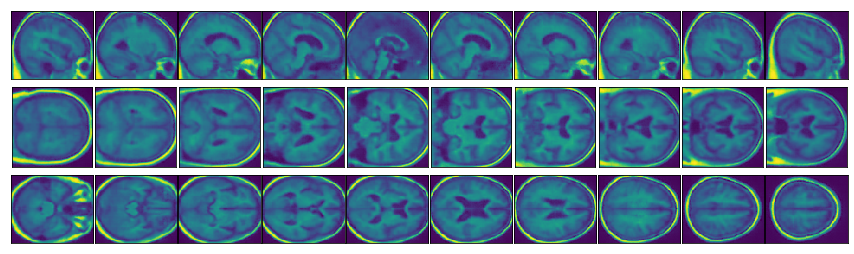

In [21]:
model.CAE.to(device)
_, _, reconstructed = model.CAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(3,10, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[2][i].matshow(reconstructed[0][:,:,20 + 5*i])
    axes[1][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [22]:
ip = pd.DataFrame(index=df.index.unique() ,columns=['onset_age','log_acceleration','s1','s2','s3','s4'])

ip['onset_age'] = individual_RER['onset_age']
ip['log_acceleration'] = individual_RER['log_acceleration']
for i in range(individual_RER['sources'].shape[1]):
    ip['s'+str(i)] = individual_RER['sources'][:,i]

## Estimation of the MSE

In [20]:
torch.cuda.empty_cache()
model.CAE.training = False

model.CAE.to(device)
test = model.train_images[:50].to(device)

with torch.no_grad():
    reconstructed = model.CAE(test)[2]

print(f"Average reconstruction L2 is {((test - reconstructed)**2).sum()/test.shape[0]}")
print(f"Mean mutual information is {mutual_information(test.cpu(), reconstructed.cpu())}")

Average reconstruction L2 is 11452.5849609375
Mean mutual information is 0.8024530270179512


In [21]:
model.CAE.to(device)
test = model.test_images[:50].to(device)

with torch.no_grad():
    reconstructed = model.CAE(test)[2]

print(f"Average reconstruction L2 is {((test - reconstructed)**2).sum()/test.shape[0]}")
print(f"Mean mutual information is {mutual_information(test.cpu(), reconstructed.cpu())}")

Average reconstruction L2 is 12023.1669921875
Mean mutual information is 0.7323858397165333


## Visual QC for reconstruction

In [22]:
template_data = data['data'][66].unsqueeze(0)

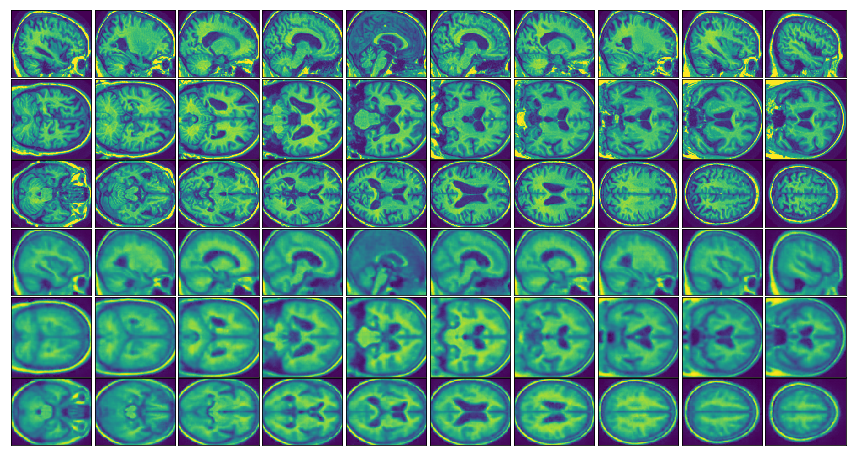

In [23]:
model.CAE.to(device)
_, _, reconstructed = model.CAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(6,10, figsize=(15,8), gridspec_kw={'height_ratios':[.8,.96,.8,.8,.96,.8]})
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[3][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))
    axes[4][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[5][i].matshow(reconstructed[0][:,:,20 + 5*i])
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

## Plotting the geodesic

In [23]:
encoded_images = torch.zeros(2*Settings().number_of_sources+1, 8, Settings().dimension)
source = torch.zeros(Settings().number_of_sources)  
t0 = model.get_reference_time()
times = [t0+i*7 for i in range(-3,5)]
#times = [40, 60, 70, 80, 90, 100, 110, 120]
for i in range(len(times)):
    t = times[i]
    encoded_images[0][i] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))

for i in range(Settings().number_of_sources):
    source = torch.zeros(Settings().number_of_sources)  
    for j in range(2):
        source[i] =  2 * (j - 1/2)
        for idx in range(len(times)):
            encoded_images[2*i+j+1][idx] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([times[idx]]).to(Settings().device),\
                                                                            sources=torch.FloatTensor(source).to(Settings().device))

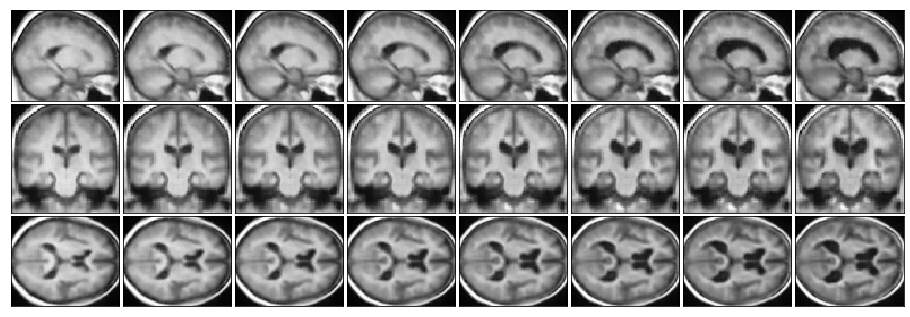

In [24]:
nrows, ncolumns = 3, encoded_images.shape[1]
fig, axes = plt.subplots(3,8, figsize=(16,5.46), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0.03, hspace=0.02)
for j in range(ncolumns):
    simulated_img = model.CAE.decoder(encoded_images[0][j].unsqueeze(0).to(device))
    axes[0][j].matshow(np.rot90(simulated_img[0][0][30].cpu().detach().numpy()), cmap='Greys_r')
    axes[1][j].matshow(np.rot90(simulated_img[0][0][:,44].cpu().detach().numpy()), cmap='Greys_r')
    axes[2][j].matshow(simulated_img[0][0][:,:,40].cpu().detach().numpy(), cmap='Greys_r')
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

## Gradient visualization

In [34]:
encoded_gradient = torch.zeros(Settings().number_of_sources+1, Settings().dimension)

source = torch.zeros(Settings().number_of_sources)  
t0 = model.get_reference_time()
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+2]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))

for i in range(Settings().number_of_sources):
    source = torch.zeros(Settings().number_of_sources)  
    source[i] =  1/4
    encoded_gradient[i+1] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0]).to(Settings().device),\
                                                                            sources=torch.FloatTensor(source).to(Settings().device))

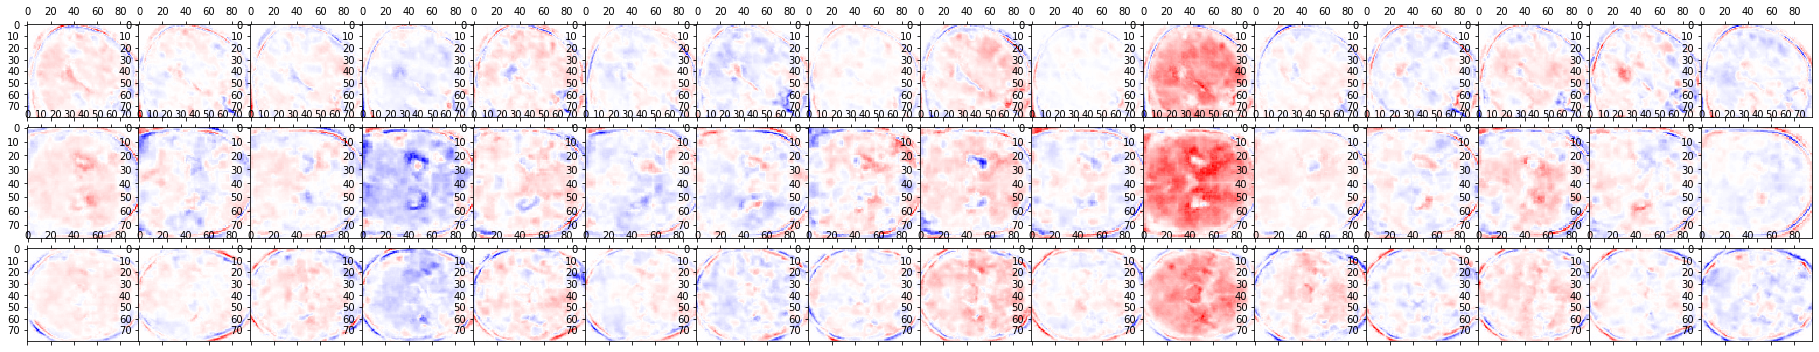

In [35]:
ncolumns = encoded_gradient.shape[0] 
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,6), gridspec_kw={'height_ratios':[.8,.96,.8]})
decoded_p0 = model.CAE.decoder(torch.zeros(encoded_gradient[0].shape).unsqueeze(0).to(device))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,ncolumns):
    simulated_img = model.CAE.decoder(encoded_gradient[i].unsqueeze(0).to(device)) - decoded_p0
    axes[0][i].matshow(np.rot90(simulated_img[0][0][58].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
    axes[1][i].matshow(simulated_img[0][0][:,30].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
    axes[2][i].matshow(simulated_img[0][0][:,:,25].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=matplotlib.colors.CenteredNorm())
#for axe in axes:
 #   for ax in axe:
  #      ax.set_xticks([])
   #     ax.set_yticks([])

## Only plot the time dimension

In [36]:
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+6]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))
decoded_p0 = model.CAE.decoder(torch.zeros(encoded_gradient[0].shape).unsqueeze(0).to(device))
simulated_img = model.CAE.decoder(encoded_gradient[0].unsqueeze(0).to(device)) - decoded_p0

In [37]:
x_slices = [8, 14, 23, 26, 32, 41, 48, 52, 58, 62, 68]

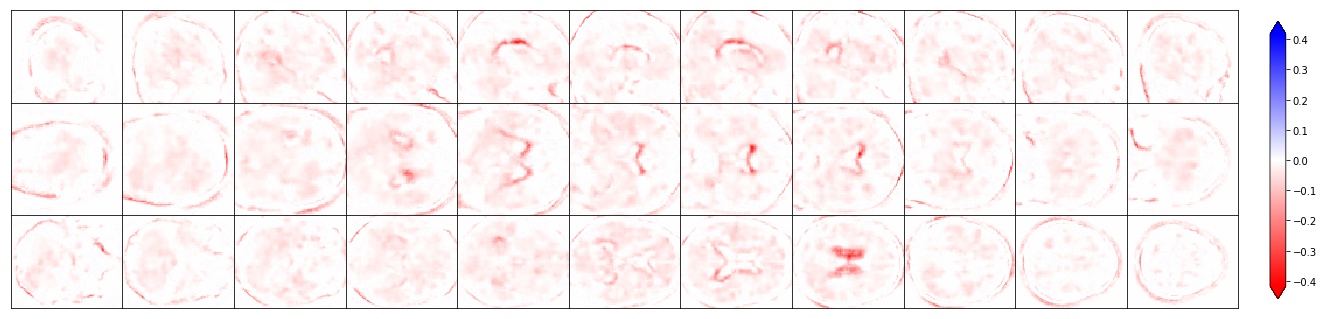

In [40]:
ncolumns = 11
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,5.5), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0, hspace=0)

vmin, vmax = simulated_img.cpu().detach().numpy().min(), simulated_img.cpu().detach().numpy().max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=-vmin)

# Threshold the artifacts
simulated_img[simulated_img>0.01]=0

for i in range(0,ncolumns):
    im1 = axes[0][i].matshow(np.rot90(simulated_img[0][0][x_slices[i]].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=norm)
    im2 = axes[1][i].matshow(simulated_img[0][0][:,10+7*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=norm)
    im3 = axes[2][i].matshow(simulated_img[0][0][:,:,8+6*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr_r'), norm=norm)
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(mappable=im1, cax=cbar_ax, extend='both')

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

## Visualization tools for individual parameters

In [25]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [26]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [27]:
ip = ip.merge(sub_diag, on='ID')
ip

onset_age  log_acceleration        s1        s2        s3        s4  \
ID                                                                          
295   79.531139         -0.541584  0.816130  0.886012 -0.531689  1.801384   
413   92.189705          0.068974 -2.036815  1.054519 -0.602753 -2.281489   
559   70.070630         -0.321117  0.078475  1.095925  1.950383  0.392496   
619   69.486661          0.294098 -0.358665 -1.202151 -1.055952  1.413781   
685   72.276899          0.174866  2.249707 -0.927705  1.114566 -0.303556   
...         ...               ...       ...       ...       ...       ...   
6570  62.578549         -0.412041 -0.261501  0.476136  0.129824  0.064900   
6574  78.040558         -0.412370 -0.562345  0.101491 -0.506507 -0.874747   
6575  86.844967          0.238023 -0.605026 -0.630911 -0.196368 -0.261348   
6580  59.288370         -0.164330  0.317293  0.021887  0.385618 -0.193375   
6581  71.480128         -0.048191  0.300101  0.220136 -0.293616  0.969441   

            s0        s5        s6        s7        s8        s9       s10  \
ID                                                                           
295   0.113924  0.692208  1.666451 -0.459970  0.117179 -0.916225  0.893653   
413   1.567382 -0.084520  2.091767  1.111181  0.621318 -0.727979 -0.547634   
559   1.042463  1.462140 -0.059395 -0.253122 -2.140738  0.987520 -1.888390   
619  -0.471665  0.765903  0.266053  1.617819 -0.451212 -0.366664 -0.618708   
685   0.126915 -0.925470 -1.730659  0.691327  0.995736  0.218591  1.960005   
...        ...       ...       ...       ...       ...       ...       ...   
6570 -0.409838 -0.003604  0.627712  0.503822 -0.377335 -0.550668 -0.213965   
6574 -0.146725 -0.179860  0.871326  0.373442  0.666581 -0.102954  0.291894   
6575 -0.654565  0.138686  1.243204 -0.464580 -0.669021  0.119333  0.011838   
6580 -0.654557  0.634845  1.121920  0.492979  0.690131 -0.706137 -0.160270   
6581 -0.681621 -0.350496  0.839501  0.206449  1.386582 -0.900209  0.180227   

           s11       s12       s13       s14 diag label  
ID                                                       
295   0.568793 -0.856550  0.302276  0.287782   CN     0  
413   2.246665 -1.921762  0.068171 -1.836841   CN     0  
559   1.829730  0.411789 -1.031697 -1.356056   CN     0  
619  -1.209270  1.508601 -0.275450 -0.253093   AD     2  
685   1.685686  0.033323 -0.520148  0.443790   CN     0  
...        ...       ...       ...       ...  ...   ...  
6570  0.027398  0.395252  0.457344  0.609508   CN     0  
6574  0.533944  0.552550 -0.126100 -0.468842   CN     0  
6575 -0.520330  0.187008 -0.597839 -0.027034   CN     0  
6580 -0.061847 -0.617320  0.844358 -0.661475   CN     0  
6581 -0.224848  0.175161 -0.448902  0.017952   CN     0  

[2143 rows x 19 columns]

<AxesSubplot:>

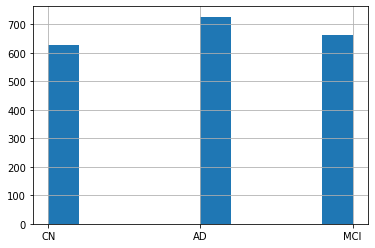

In [28]:
ip['diag'].hist()

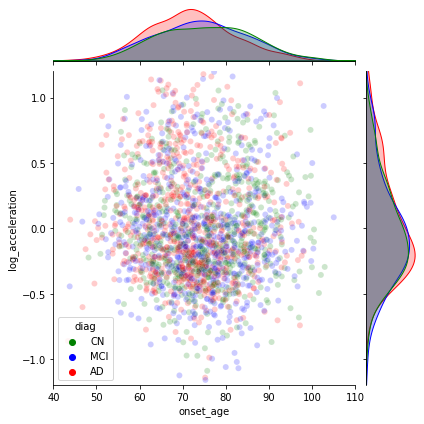

In [33]:
import seaborn as sns

sns.jointplot(data = ip,
                x = 'onset_age', 
                y = 'log_acceleration', 
                hue = 'diag',
                hue_order = ['CN', 'MCI', 'AD'],
                alpha=0.2, 
                palette = ['g', 'b', 'r'],
                xlim = (40,110),
                ylim = (-1.2,1.2))

plt.show()

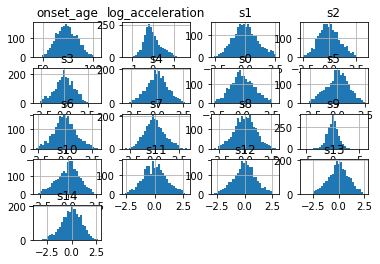

In [30]:
ip.hist(bins=30)
plt.show()

In [31]:
ip

onset_age  log_acceleration        s1        s2        s3        s4  \
ID                                                                          
295   79.531139         -0.541584  0.816130  0.886012 -0.531689  1.801384   
413   92.189705          0.068974 -2.036815  1.054519 -0.602753 -2.281489   
559   70.070630         -0.321117  0.078475  1.095925  1.950383  0.392496   
619   69.486661          0.294098 -0.358665 -1.202151 -1.055952  1.413781   
685   72.276899          0.174866  2.249707 -0.927705  1.114566 -0.303556   
...         ...               ...       ...       ...       ...       ...   
6570  62.578549         -0.412041 -0.261501  0.476136  0.129824  0.064900   
6574  78.040558         -0.412370 -0.562345  0.101491 -0.506507 -0.874747   
6575  86.844967          0.238023 -0.605026 -0.630911 -0.196368 -0.261348   
6580  59.288370         -0.164330  0.317293  0.021887  0.385618 -0.193375   
6581  71.480128         -0.048191  0.300101  0.220136 -0.293616  0.969441   

            s0        s5        s6        s7        s8        s9       s10  \
ID                                                                           
295   0.113924  0.692208  1.666451 -0.459970  0.117179 -0.916225  0.893653   
413   1.567382 -0.084520  2.091767  1.111181  0.621318 -0.727979 -0.547634   
559   1.042463  1.462140 -0.059395 -0.253122 -2.140738  0.987520 -1.888390   
619  -0.471665  0.765903  0.266053  1.617819 -0.451212 -0.366664 -0.618708   
685   0.126915 -0.925470 -1.730659  0.691327  0.995736  0.218591  1.960005   
...        ...       ...       ...       ...       ...       ...       ...   
6570 -0.409838 -0.003604  0.627712  0.503822 -0.377335 -0.550668 -0.213965   
6574 -0.146725 -0.179860  0.871326  0.373442  0.666581 -0.102954  0.291894   
6575 -0.654565  0.138686  1.243204 -0.464580 -0.669021  0.119333  0.011838   
6580 -0.654557  0.634845  1.121920  0.492979  0.690131 -0.706137 -0.160270   
6581 -0.681621 -0.350496  0.839501  0.206449  1.386582 -0.900209  0.180227   

           s11       s12       s13       s14 diag label  
ID                                                       
295   0.568793 -0.856550  0.302276  0.287782   CN     0  
413   2.246665 -1.921762  0.068171 -1.836841   CN     0  
559   1.829730  0.411789 -1.031697 -1.356056   CN     0  
619  -1.209270  1.508601 -0.275450 -0.253093   AD     2  
685   1.685686  0.033323 -0.520148  0.443790   CN     0  
...        ...       ...       ...       ...  ...   ...  
6570  0.027398  0.395252  0.457344  0.609508   CN     0  
6574  0.533944  0.552550 -0.126100 -0.468842   CN     0  
6575 -0.520330  0.187008 -0.597839 -0.027034   CN     0  
6580 -0.061847 -0.617320  0.844358 -0.661475   CN     0  
6581 -0.224848  0.175161 -0.448902  0.017952   CN     0  

[2143 rows x 19 columns]

TypeError: Neither the `x` nor `y` variable appears to be numeric.

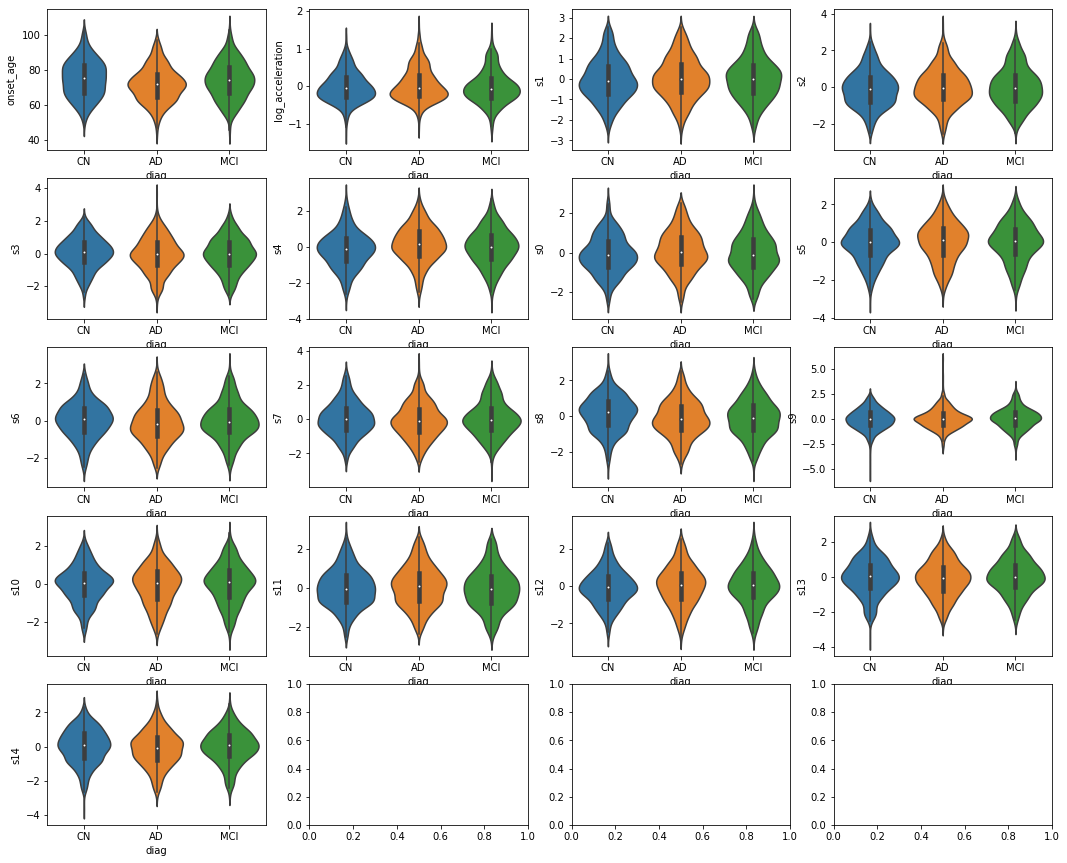

In [32]:
columns = ip.columns
n_rows, n_cols = len(ip.columns)//4 + 1, 4
fig, axes = plt.subplots(n_rows,n_cols, figsize=(18,3*n_rows))

for i in range(len( ip.columns)):
    sns.violinplot(x='diag', y=columns[i], data=ip, ax=axes[i//4][i%4])

## Extrapolate one patient's trajectory

In [20]:
data['RID'][104:112]

tensor([1268, 1268, 1268, 1268, 1268, 1268, 1268, 1268])

In [21]:
for sub in ip.index.unique():
    sub_data = ip.loc[sub]
    if len(sub_data)>6:
        if 'AD' in sub_data.values:
            if sub==1268:
                print(sub)

/tmp/ipykernel_806830/3490351031.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'AD' in sub_data.values:


Onset age is 56.418706 and log_acceleration is -0.068775


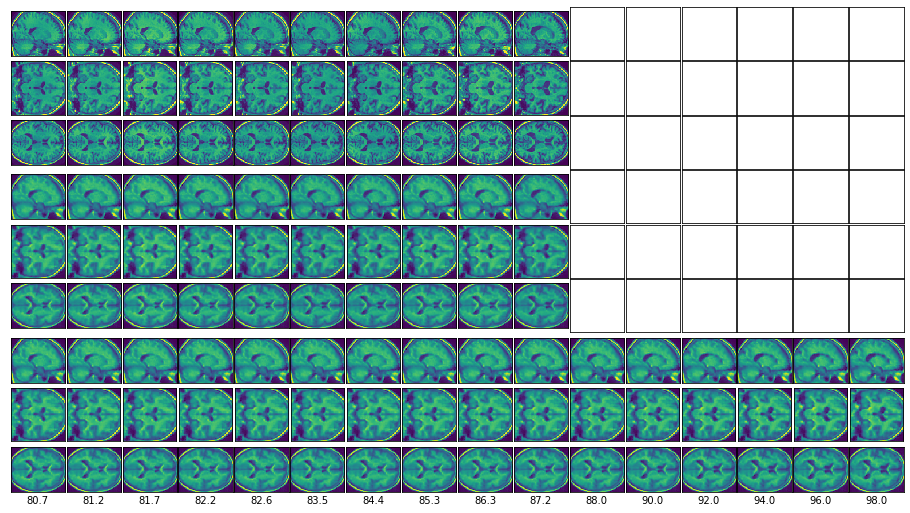

In [29]:
model.CAE.to(device)

sub_idx = 38
nb_visits = 10
prediction_timepoints = [88, 90, 92, 94, 96, 98]

fig, axes = plt.subplots(nrows=9, ncols=16, figsize=(16,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

onset_age, log_acceleration, source = individual_RER['onset_age'][int(data['labels'][sub_idx])], individual_RER['log_acceleration'][int(data['labels'][sub_idx])], individual_RER['sources'][int(data['labels'][sub_idx])]
print(f"Onset age is {onset_age} and log_acceleration is {log_acceleration}")

for i in range(16):
    if i < nb_visits:
        axes[0][i].matshow(np.rot90(data['data'][sub_idx+i][30]))
        axes[1][i].matshow(data['data'][sub_idx+i][:,44])
        axes[2][i].matshow(data['data'][sub_idx+i][:,:,40])
        
        reconstructed = model.CAE.decoder(torch.FloatTensor(model.full_encoded[sub_idx+i].unsqueeze(0)).to(device))
        reconstructed = reconstructed.cpu().detach().numpy()[0]
        axes[3][i].matshow(np.rot90(reconstructed[0][30]))
        axes[4][i].matshow(reconstructed[0][:,44])
        axes[5][i].matshow(reconstructed[0][:,:,40])
        
        timepoint = data['timepoints'][38+i]
        reparametrized_age = np.exp(log_acceleration) * (timepoint - onset_age) + individual_RER['onset_age'].mean()
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]))
        axes[7][i].matshow(expected_image[0][:,44])
        axes[8][i].matshow(expected_image[0][:,:,40])
            
    else:
        reparametrized_age = prediction_timepoints[i - nb_visits]
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]))
        axes[7][i].matshow(expected_image[0][:,44])
        axes[8][i].matshow(expected_image[0][:,:,40])
        
    if i == 9:
        true_vis = data['data'][sub_idx+i]
        rec_vis = reconstructed[0]
        pred_vis_now = expected_image
    if i == 15:
        pred_vis_then = expected_image[0]
            
    axes[8][i].set_xlabel(np.around(float(reparametrized_age),1))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

In [30]:
print(f"Leaspy now : {((true_vis - pred_vis_now)**2).sum()}, leaspy future : {((true_vis - pred_vis_then)**2).sum()}, reconstruction error :  {((true_vis - rec_vis)**2).sum()}")

Leaspy now : 7646.001953125, leaspy future : 8336.3095703125, reconstruction error :  7127.5107421875


In [31]:
print(f"Leaspy now : {mutual_information(true_vis, pred_vis_now)}, leaspy future : {mutual_information(true_vis, pred_vis_then)}, reconstruction error :  {mutual_information(true_vis, rec_vis)}")


Leaspy now : 0.9485425169176172, leaspy future : 0.9017379389037393, reconstruction error :  0.9517703714094305


In [32]:
mutual_information(true_vis, true_vis)

2.6647179503523377

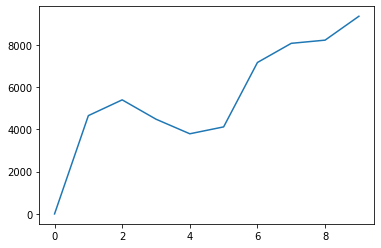

In [25]:
plt.plot([((data['data'][sub_idx+i] - data['data'][sub_idx])**2).sum() for i in range(10)])

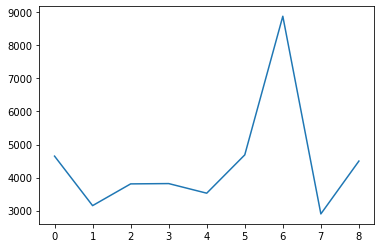

In [26]:
plt.plot([((data['data'][sub_idx+(i+1)] - data['data'][sub_idx+i])**2).sum() for i in range(9)])

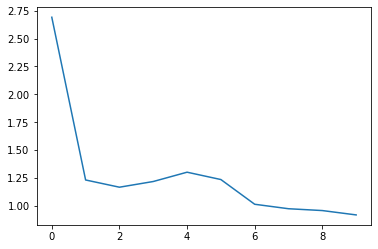

In [38]:
plt.plot([mutual_information(data['data'][sub_idx+i], data['data'][sub_idx]) for i in range(10)])

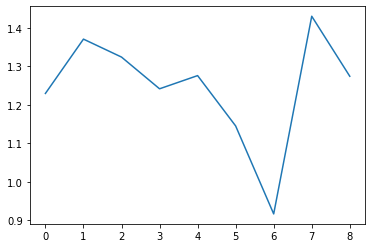

In [39]:
plt.plot([mutual_information(data['data'][sub_idx+(i+1)], data['data'][sub_idx+i]) for i in range(9)])

Onset age is 72.912981 and log_acceleration is 0.328282
tensor(65.1000, dtype=torch.float64)
tensor(65.7000, dtype=torch.float64)
tensor(66.2000, dtype=torch.float64)
tensor(66.7000, dtype=torch.float64)
tensor(67.2000, dtype=torch.float64)
tensor(68.1000, dtype=torch.float64)
tensor(69.1000, dtype=torch.float64)
tensor(70.1000, dtype=torch.float64)


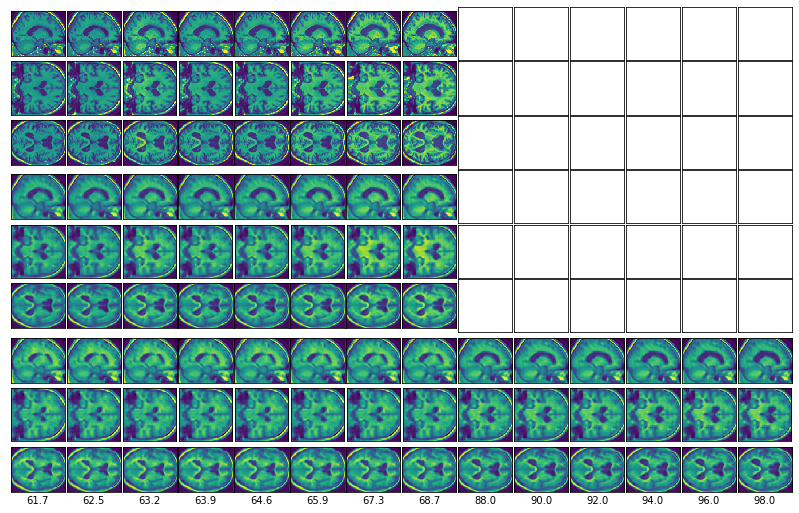

In [21]:
model.CAE.to(device)

sub_idx = 104
nb_visits = 8
prediction_timepoints = [88, 90, 92, 94, 96, 98]

fig, axes = plt.subplots(nrows=9, ncols=14, figsize=(14,9))
plt.subplots_adjust(wspace=0.03, hspace=0.02)

onset_age, log_acceleration, source = individual_RER['onset_age'][int(data['labels'][sub_idx])], individual_RER['log_acceleration'][int(data['labels'][sub_idx])], individual_RER['sources'][int(data['labels'][sub_idx])]
print(f"Onset age is {onset_age} and log_acceleration is {log_acceleration}")

for i in range(14):
    if i < nb_visits:
        axes[0][i].matshow(np.rot90(data['data'][sub_idx+i][30]))
        axes[1][i].matshow(data['data'][sub_idx+i][:,44])
        axes[2][i].matshow(data['data'][sub_idx+i][:,:,40])
        
        reconstructed = model.CAE.decoder(torch.FloatTensor(model.full_encoded[sub_idx+i].unsqueeze(0)).to(device))
        reconstructed = reconstructed.cpu().detach().numpy()[0]
        axes[3][i].matshow(np.rot90(reconstructed[0][30]))
        axes[4][i].matshow(reconstructed[0][:,44])
        axes[5][i].matshow(reconstructed[0][:,:,40])
        
        timepoint = data['timepoints'][38+i]
        print(timepoint)
        reparametrized_age = np.exp(log_acceleration) * (timepoint - onset_age) + individual_RER['onset_age'].mean()
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]))
        axes[7][i].matshow(expected_image[0][:,44])
        axes[8][i].matshow(expected_image[0][:,:,40])
            
    else:
        reparametrized_age = prediction_timepoints[i - nb_visits]
        expected_position = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([reparametrized_age]).to(device), sources=torch.FloatTensor(source).to(device))
        expected_image = model.CAE.decoder(expected_position.unsqueeze(0))
        expected_image = expected_image.cpu().detach().numpy()[0]
        axes[6][i].matshow(np.rot90(expected_image[0][30]))
        axes[7][i].matshow(expected_image[0][:,44])
        axes[8][i].matshow(expected_image[0][:,:,40])
        
    if i == 8:
        true_vis = data['data'][sub_idx+i]
        rec_vis = reconstructed[0]
        pred_vis_now = expected_image
    if i == 13:
        pred_vis_then = expected_image[0]

    axes[8][i].set_xlabel(np.around(float(reparametrized_age),1))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

In [22]:
((true_vis - pred_vis_now)**2).sum()

tensor(42284.2070)

In [23]:
((true_vis - pred_vis_then)**2).sum()

tensor(43005.0820)

In [24]:
((true_vis - rec_vis)**2).sum()

tensor(45163.0859)

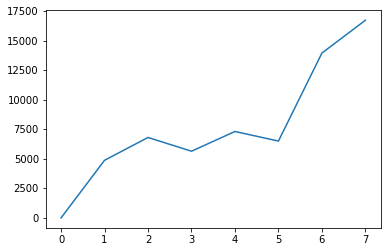

In [25]:
plt.plot([((data['data'][sub_idx+i] - data['data'][sub_idx])**2).sum() for i in range(8)])

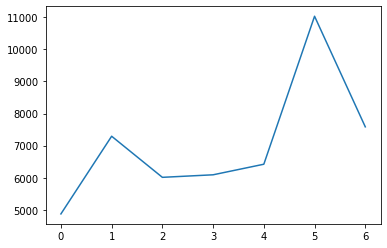

In [26]:
plt.plot([((data['data'][sub_idx+(i+1)] - data['data'][sub_idx+i])**2).sum() for i in range(7)])

## PLS on latent space to predict cognitive score

In [47]:
MMSE = caps_info.loc[ip.index][['TIME','MMSE']].dropna()
MMSE['MMSE'] = MMSE['MMSE']/30
MMSE['MMSE'] = 1 - MMSE['MMSE'] 
MMSE['ID'] = MMSE.index
MMSE = MMSE.set_index(['ID', 'TIME'])
MMSE = MMSE[~MMSE.index.duplicated(keep='first')]

In [48]:
ADAS = caps_info.loc[ip.index][['TIME','adas13']].dropna()
ADAS['adas13'] = ADAS['adas13']/85
ADAS['ID'] = ADAS.index
ADAS = ADAS.set_index(['ID', 'TIME'])
ADAS = ADAS[~ADAS.index.duplicated(keep='first')]

In [49]:
encoded = pd.DataFrame(model.full_encoded).astype('float')
encoded['ID'] = data['RID']
encoded['TIME'] = model.full_timepoints
encoded = encoded.set_index(['ID','TIME'])
encoded = encoded[~encoded.index.duplicated(keep='first')]

In [50]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

X = encoded
y = pd.concat((MMSE,ADAS), axis=1).dropna()

subs = [sub for sub in X.index if sub in y.index]
X, y = X.loc[subs], y.loc[subs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pls2 = PLSRegression(n_components=1)
pls2.fit(X_train, y_train)
y_pred_test = pls2.predict(X_test)
print(np.sqrt(((y_pred_test - y_test)**2).mean()))

MMSE      0.118764
adas13    0.126472
dtype: float64


In [51]:
y.describe()

MMSE       adas13
count  8996.000000  8996.000000
mean      0.103805     0.203630
std       0.121659     0.129927
min       0.000000     0.000000
25%       0.033333     0.105882
50%       0.066667     0.176471
75%       0.166667     0.270588
max       1.000000     0.988235

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = encoded
y = ADAS.dropna()

feat = 'adas'

subs = [sub for sub in X.index if sub in y.index]
X, y = X.loc[subs], y.loc[subs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train -= X_train.mean()
X_train /= X_train.std()
X_test -= X_test.mean()
X_test /= X_test.std()
#y_train -= y_train.mean()
#y_train /= y_train.std()
#y_test -= y_test.mean()
#y_test /= y_test.std()

In [53]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma=0.01)
svr_poly = SVR(kernel='poly', C=100, gamma=0.01, degree=3, epsilon=.1,
               coef0=1)

svrs = [svr_rbf, svr_lin, svr_poly]

for svr in svrs[:1]:
    print(svr)
    regr = svr.fit(X_train,y_train)
    
    y_pred = pd.DataFrame(regr.predict(X_train))
    y_pred.index = X_train.index
    y_pred.columns = [feat]

    y_pred_t = pd.DataFrame(regr.predict(X_test))
    y_pred_t.index = X_test.index
    y_pred_t.columns = [feat]

    print(f"train error = {np.sqrt(mean_squared_error(y_pred, y_train))}")
    print(f"test error = {np.sqrt(mean_squared_error(y_pred_t, y_test))}")
    print(f"r2 train = {r2_score(y_train,y_pred)}")
    print(f"r2 test = {r2_score(y_test,y_pred_t)}")

SVR(C=10, gamma='auto')


/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


train error = 0.06979333965448489
test error = 0.09460781465772426
r2 train = 0.7118464213047538
r2 test = 0.4843696636033411


## Distribution of encoded representations

In [ ]:
encoded_df = pd.DataFrame(model.full_encoded, dtype=np.float)

In [ ]:
encoded_df.hist(bins=30, figsize=(15,15), sharex=True)
plt.show()

## PCA on random effects

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

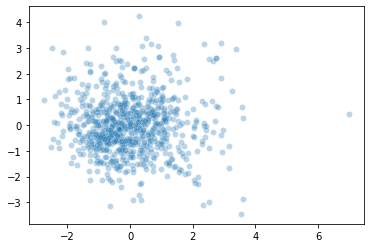

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import decomposition
from sklearn import datasets

X = ip
X = (X-X.mean())/X.std()

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

sns.scatterplot(X[:, 0], X[:, 1], alpha=.3)

## Plot the freesurfer volumes with reparametrized age

In [34]:
df = df.loc[ip.index]

df['t_hat'] = np.exp(ip.loc[df.index]['log_acceleration']) * (df['TIME'] - ip.loc[df.index]['onset_age']) + 72.5
df['ID'] = df.index
test = df.set_index(['ID','TIME'])

<AxesSubplot:xlabel='t_hat', ylabel='Count'>

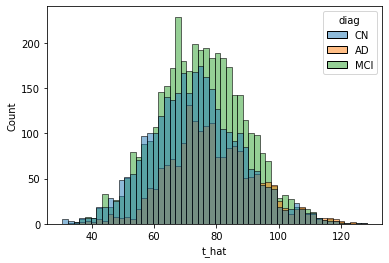

In [35]:
df['ID'] = df.index
test = df.set_index(['ID','TIME'])
test = test[~test.index.duplicated(keep='first')]
test = test[test['t_hat'].between(30,130)]

sns.histplot(data=test, x='t_hat', hue='diag')

<AxesSubplot:xlabel='TIME', ylabel='Count'>

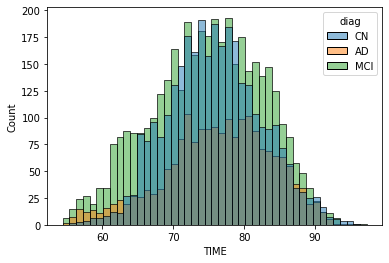

In [36]:
sns.histplot(data=test, x='TIME', hue='diag')

<AxesSubplot:xlabel='diag', ylabel='t_hat'>

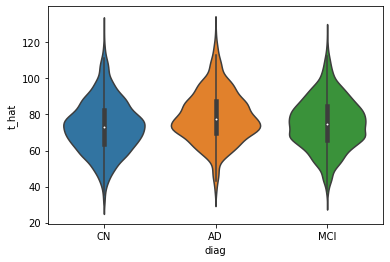

In [37]:
sns.violinplot(data=test, y='t_hat', x='diag')

<AxesSubplot:xlabel='diag', ylabel='t_hat'>

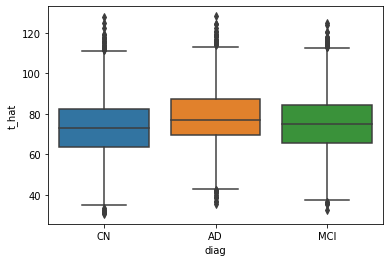

In [38]:
sns.boxplot(data=test, y='t_hat', x='diag')

In [67]:
columns = ["RID","AGE_vis","MES_MRI_HIPPOCAMPUS_ICV","MES_MRI_VENTRICLES_ICV", "DX"]
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', usecols=columns,
                       sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME', 'DX':'diag'}, inplace=True)
img_data = img_data.set_index('ID')

In [68]:
img_data = img_data.loc[ip.index]
img_data = img_data.dropna()

img_data['t_hat'] = np.exp(ip.loc[img_data.index]['log_acceleration']) * (img_data['TIME'] - ip.loc[img_data.index]['onset_age']) + 72.5
img_data = img_data[img_data['t_hat'].between(30,130)]

<AxesSubplot:xlabel='t_hat', ylabel='MES_MRI_HIPPOCAMPUS_ICV'>

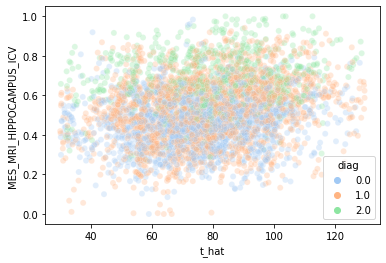

In [69]:
sns.scatterplot(data=img_data, x='t_hat', y='MES_MRI_HIPPOCAMPUS_ICV', hue='diag', alpha=.3, palette='pastel')

<AxesSubplot:xlabel='t_hat', ylabel='MES_MRI_VENTRICLES_ICV'>

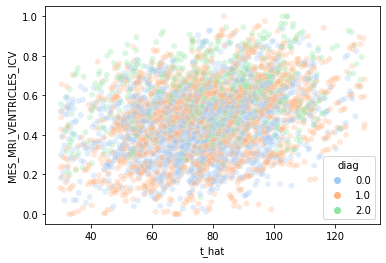

In [70]:
sns.scatterplot(data=img_data, x='t_hat', y='MES_MRI_VENTRICLES_ICV', hue='diag', alpha=.3, palette='pastel')

<AxesSubplot:xlabel='MES_MRI_HIPPOCAMPUS_ICV', ylabel='MES_MRI_VENTRICLES_ICV'>

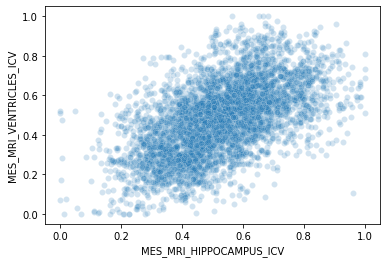

In [71]:
sns.scatterplot(data=img_data, x='MES_MRI_HIPPOCAMPUS_ICV', y='MES_MRI_VENTRICLES_ICV', alpha=.2)

<AxesSubplot:xlabel='t_hat', ylabel='MMSE'>

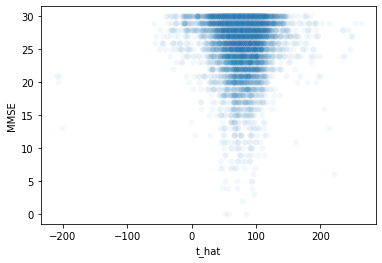

In [72]:
sns.scatterplot(data=df, x='t_hat', y='MMSE', alpha=.05)

## Statistical tests to link ip with covariates

In [97]:
from scipy.stats import mannwhitneyu

In [98]:
sex = caps_info[~caps_info.index.duplicated(keep='first')]['sex']
ip = ip.merge(sex, on='ID')

In [99]:
onset_men = ip.loc[ip['sex']=='M']['onset_age']
onset_women = ip.loc[ip['sex']=='F']['onset_age']

_,p = mannwhitneyu(onset_women, onset_men)

print(f"Onset age for men is {onset_men.mean():.4f} and for women {onset_women.mean():.4f} wich differs with pvalue : {p}")

Onset age for men is 72.1227 and for women 72.9357 wich differs with pvalue : 0.019466452869571882


In [100]:
xi_men = ip.loc[ip['sex']=='M']['log_acceleration']
xi_women = ip.loc[ip['sex']=='F']['log_acceleration']

_, p = mannwhitneyu(xi_women, xi_men)

print(f"Xi for men is {xi_men.mean():.4f} and for women {xi_women.mean():.4f} wich differs with pvalue : {p}")

Xi for men is 0.0067 and for women -0.0035 wich differs with pvalue : 0.3141418379110685


In [101]:
apoe = caps_info[~caps_info.index.duplicated(keep='first')]['apoe4'].dropna()
ip = ip.merge(apoe, on='ID')

In [102]:
onset_cn = ip.loc[ip['apoe4']==0]['onset_age']
onset_apoe = ip.loc[ip['apoe4']!=0]['onset_age']

_,p = mannwhitneyu(onset_cn, onset_apoe)

print(f"Onset age for non-APOE carriers is {onset_cn.mean():.4f} and for carriers {onset_apoe.mean():.4f} wich differs with pvalue : {p}")

Onset age for non-APOE carriers is 72.7602 and for carriers 72.1757 wich differs with pvalue : 0.08737184291692013


In [103]:
xi_cn = ip.loc[ip['apoe4']==0]['log_acceleration']
xi_apoe = ip.loc[ip['apoe4']!=0]['log_acceleration']

_,p = mannwhitneyu(xi_cn, xi_apoe)

print(f"Xi for non-APOE carriers is {xi_cn.mean():.4f} and for carriers {xi_apoe.mean():.4f} wich differs with pvalue : {p}")

Xi for non-APOE carriers is -0.0108 and for carriers 0.0198 wich differs with pvalue : 0.09786568907457749


## Evaluation of MCMC convergence

In [73]:
rer = np.load('output_CVAE_16_MRI_15_sources/LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
#trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
 #      allow_pickle=True)[()]
ids = pd.read_csv('output_CVAE_16_MRI_15_sources/LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

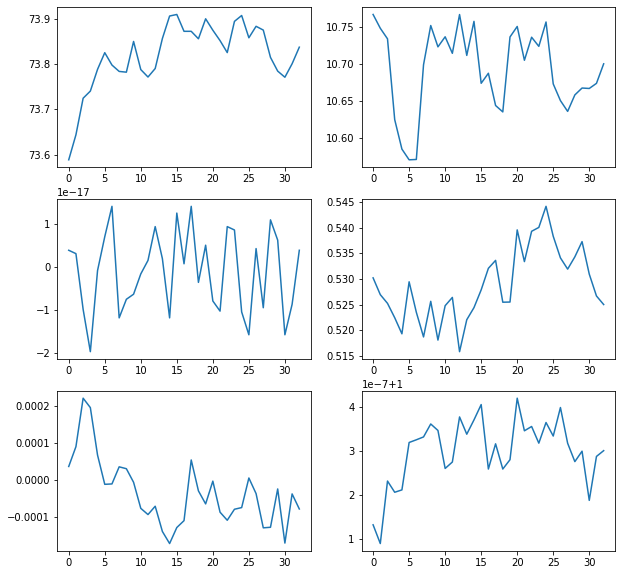

In [74]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

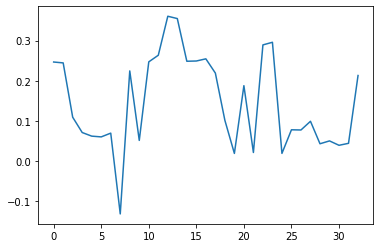

In [78]:
plt.plot(rer['log_acceleration'][:,50])

## How much every latent dimension contributes to the temporal variation

In [69]:
encoded = pd.DataFrame(model.full_encoded).astype('float')
encoded['ID'] = model.full_labels
encoded['TIME'] = model.full_timepoints
encoded = encoded.set_index('ID')

In [70]:
variation = pd.DataFrame(index=encoded.index.unique(), columns=encoded.columns)

for sub in encoded.index.unique():
    encoded_sub = encoded.loc[sub]
    if type(encoded_sub) != pd.core.series.Series:
        visit_1 = encoded_sub.iloc[0]
        visit_2 = encoded_sub.iloc[-1]
        variation.loc[sub] = visit_2 - visit_1
    else:
        variation.drop(sub)
        
variation = variation.astype('float').dropna().drop('TIME', axis=1)
variation['total_variation'] = np.sqrt((variation**2).sum(axis=1))
variation = variation.div(variation['total_variation'], axis=0)
variation = variation**2

In [71]:
variation.describe()

0             1             2             3             4  \
count  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03   
mean   3.639966e-01  3.099391e-02  3.300053e-02  2.886401e-02  2.614860e-02   
std    2.946995e-01  5.174029e-02  5.545850e-02  5.046908e-02  4.454286e-02   
min    1.224855e-08  7.807971e-10  9.181809e-10  1.295952e-08  2.980172e-11   
25%    9.137784e-02  2.150444e-03  1.976337e-03  1.665120e-03  1.908519e-03   
50%    3.029008e-01  1.045869e-02  1.121491e-02  9.319320e-03  8.420345e-03   
75%    6.083743e-01  3.744473e-02  3.985867e-02  3.308722e-02  3.153574e-02   
max    9.903566e-01  4.478726e-01  4.986601e-01  5.626081e-01  5.177111e-01   

                  5             6             7             8             9  \
count  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03   
mean   3.549854e-02  3.382616e-02  3.449236e-02  3.198407e-02  5.889094e-02   
std    4.711670e-02  5.952221e-02  5.446126e-02  5.506774e-02  8.972698e-02   
min    2.313088e-09  3.544175e-08  1.011169e-09  5.575889e-10  4.265518e-11   
25%    3.616614e-03  2.118550e-03  2.678322e-03  2.043850e-03  4.774468e-03   
50%    1.680336e-02  1.034331e-02  1.383106e-02  1.082498e-02  2.159508e-02   
75%    5.013425e-02  3.762884e-02  4.171400e-02  3.491311e-02  7.171182e-02   
max    4.559988e-01  5.294827e-01  6.417067e-01  5.136183e-01  6.461561e-01   

                 10            11            12            13            14  \
count  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03  1.819000e+03   
mean   1.625602e-01  3.241182e-02  2.755622e-02  3.175670e-02  3.040153e-02   
std    1.823302e-01  5.486520e-02  4.630981e-02  5.363101e-02  5.035292e-02   
min    9.233321e-07  2.003852e-09  3.246447e-09  3.539159e-09  8.627231e-09   
25%    1.973960e-02  1.973446e-03  1.859021e-03  2.003152e-03  2.322158e-03   
50%    8.860938e-02  1.002941e-02  9.909957e-03  1.065295e-02  1.122419e-02   
75%    2.496475e-01  3.763736e-02  3.182168e-02  3.730627e-02  3.424832e-02   
max    8.360195e-01  6.403337e-01  4.143982e-01  4.685077e-01  3.867349e-01   

                 15  total_variation  
count  1.819000e+03           1819.0  
mean   3.761784e-02              1.0  
std    5.800611e-02              0.0  
min    1.730278e-07              1.0  
25%    2.920435e-03              1.0  
50%    1.474047e-02              1.0  
75%    4.760337e-02              1.0  
max    4.870928e-01              1.0

## Display the evolution of latent encodings

In [39]:
# First with the trained longitudinal model

z = model.full_encoded[:38]
labels = model.full_labels[:38]

already_seen = []
alpha = []
for i in range(len(labels)):
    if labels[i] not in already_seen:
        alpha.append(1)
        already_seen.append(labels[i])
    else:
        alpha.append(alpha[-1] * .85)

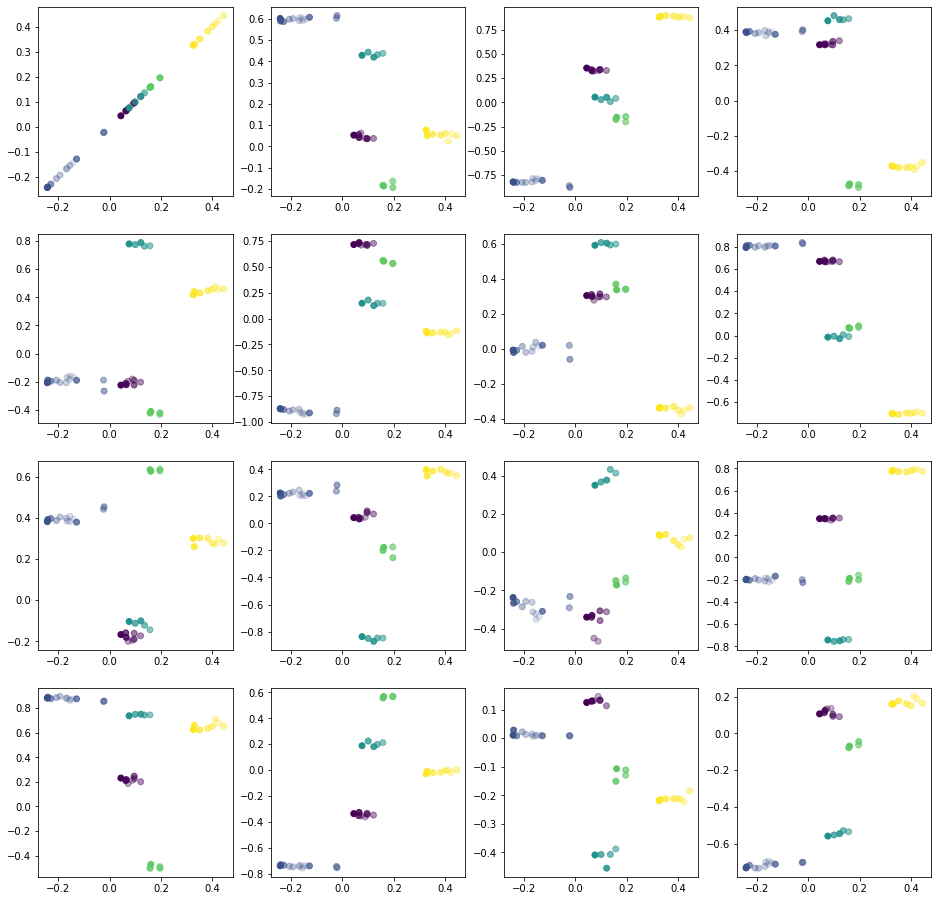

In [40]:
fig, axes = plt.subplots(4,4, figsize=(16,16))

for i in range(16):
    axes[i//4][i%4].scatter(z[:,0], z[:,i], c=labels, alpha=alpha)

In [24]:
# Then with a random VAE

vae = CVAE_3D()
vae.load_state_dict(torch.load('../CVAE_3D_t1_16'))

<All keys matched successfully>

In [25]:
vae.to(device)
vae.eval() 
with torch.no_grad():
    output = vae(data['data'][:38].unsqueeze(1).to(device))

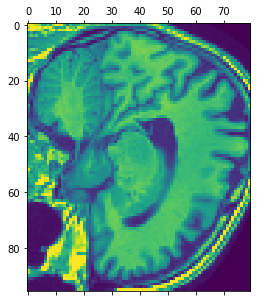

In [26]:
plt.matshow(data['data'][0][50])

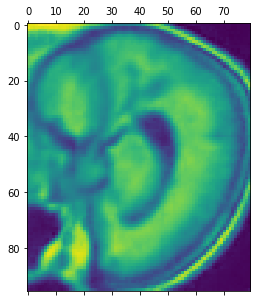

In [27]:
plt.matshow(output[2][0][0][50].cpu().detach().numpy())

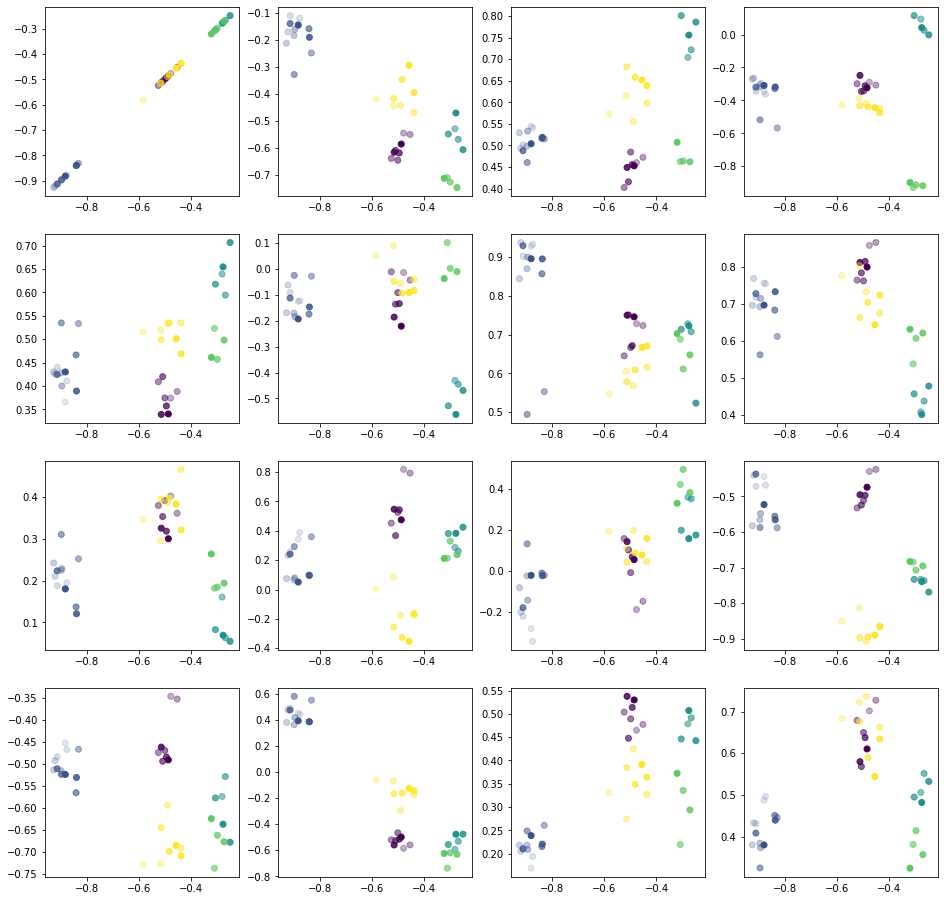

In [31]:
fig, axes = plt.subplots(4,4, figsize=(16,16))

z_vae = output[0].cpu().detach().numpy()
for i in range(16):
    axes[i//4][i%4].scatter(z_vae[:,0], z_vae[:,i], c=labels, alpha=alpha)

In [104]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
z_vae_pca = pca.fit_transform(z_vae)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.5422459  0.190641   0.14319682 0.06577943 0.02564351]
[3.5721676 2.1180775 1.8356943 1.2441672 0.7768235]


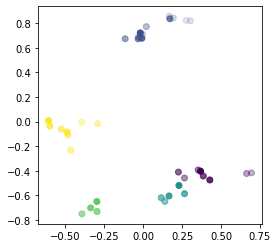

In [105]:
from matplotlib.pyplot import figure
figure(figsize=(4,4))
plt.scatter(z_vae_pca[:,1], z_vae_pca[:,0], c=labels, alpha=alpha)

In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
z_vae_pca = pca.fit_transform(model.full_encoded)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.09405684 0.08522989 0.08038514 0.07481262 0.0723063 ]
[50.28889991 47.87104457 46.49056651 44.85019856 44.0925313 ]


In [107]:
z_vae_pca.shape

(10047, 5)

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(4,4))
plt.scatter(z_vae_pca[:38,0], z_vae_pca[:38,1], c=labels, alpha=alpha)

## Do the same thing for test images

In [41]:
# First with the trained longitudinal model

z = model.test_encoded[:40]
labels = model.test_labels[:40]

already_seen = []
alpha = []
for i in range(len(labels)):
    if labels[i] not in already_seen:
        alpha.append(1)
        already_seen.append(labels[i])
    else:
        alpha.append(alpha[-1] * .85)

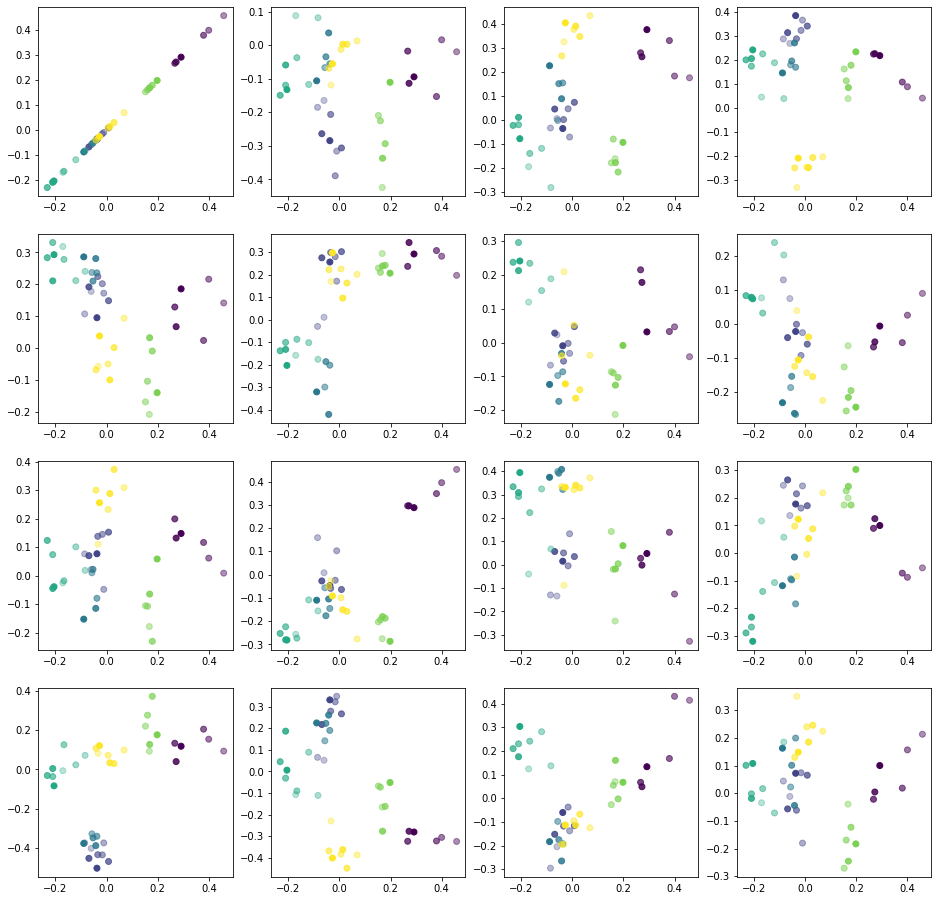

In [42]:
fig, axes = plt.subplots(4,4, figsize=(16,16))

for i in range(16):
    axes[i//4][i%4].scatter(z[:,0], z[:,i], c=labels, alpha=alpha)

## Univariate MMSE to compare the indiviudal parameters

In [82]:
MMSE = caps_info.loc[ip.index][['TIME','MMSE']].dropna()
MMSE['MMSE'] = MMSE['MMSE']/30
MMSE['MMSE'] = 1 - MMSE['MMSE'] 

In [83]:
# import leaspy

path_leaspy = '/home/benoit.sautydechalon/leaspy/'
sys.path.append(path_leaspy)

from leaspy import Leaspy, Data, IndividualParameters, AlgorithmSettings

In [84]:
# Settings
n_iter = 8000
settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter)

# Fitting the model

leaspy = Leaspy('univariate_logistic')
data_leaspy = Data.from_dataframe(MMSE)
leaspy.fit(data_leaspy, settings)

settings_2 = AlgorithmSettings('scipy_minimize', n_jobs=30)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
ip_mmse = individual_parameters.to_dataframe()
ip_mmse.index = [int(sub) for sub in ip_mmse.index]
ip_mmse.index.name = 'ID'

|##################################################|   8000/8000 iterations
Fit with `mcmc_saem` took: 1m 5s
The standard deviation of the noise at the end of the fit is:
4.64%
|##################################################|   2100/2113 subjects
Personalize with `scipy_minimize` took: 3m 59s
The standard deviation of the noise at the end of the personalize is:
3.99%


In [85]:
ip_mmse.mean()

xi     -1.705437
tau    73.075829
dtype: float64

In [86]:
ip_mmse['xi'] = ip_mmse['xi'] - ip_mmse['xi'].mean()
ip_mmse = ip_mmse - ip_mmse.mean()
ip_mmse = ip_mmse / ip_mmse.std()
ip_mmse.head()

xi       tau
ID                     
295  1.059960  1.761425
413 -0.059261  2.426062
559 -0.128059  1.394436
619 -0.174380 -1.027898
685 -1.957131  1.255467

In [87]:
ip_lvae = ip[['onset_age', 'log_acceleration']]
ip_lvae.columns = ['tau_vae', 'xi_vae']
ip_lvae = ip_lvae - ip_lvae.mean()
ip_lvae = ip_lvae / ip_lvae.std()
ip_lvae.head()

tau_vae    xi_vae
ID                     
295  0.514001 -0.955949
413  1.716838  0.127846
559  0.071886  0.411597
619 -0.175406  0.870333
685  0.027086  0.389805

In [88]:
ip_total = ip_img.merge(ip_lvae, on='ID')
ip_total.corr()

NameError: name 'ip_img' is not defined

### Link between MMSE and freesurfer

In [175]:
ip_total = ip_img.merge(ip_mmse, on='ID')
ip_total.corr()

xi_x     tau_x  sources_0      xi_y     tau_y
xi_x       1.000000 -0.218027  -0.146774  0.377241 -0.249951
tau_x     -0.218027  1.000000   0.061641 -0.339666  0.431316
sources_0 -0.146774  0.061641   1.000000 -0.129589  0.151292
xi_y       0.377241 -0.339666  -0.129589  1.000000 -0.094581
tau_y     -0.249951  0.431316   0.151292 -0.094581  1.000000

## Multivariate on hippocampus and ventricles to compare

In [165]:
columns = ['RID','AGE_vis', 'MES_MRI_HIPPOCAMPUS_ICV','MES_MRI_VENTRICLES_ICV', 'MES_MRI_AMYGDALA_ICV']
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', 
                   usecols=columns, sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME'}, inplace=True)
img_data = img_data.set_index('ID')

In [167]:
# Settings
n_iter = 8000
n_sources = 1
settings = AlgorithmSettings('mcmc_saem', n_iter=n_iter)

# Fitting the model

leaspy = Leaspy('logistic')
leaspy.model.load_hyperparameters({'source_dimension': n_sources})
data_leaspy = Data.from_dataframe(img_data)
leaspy.fit(data_leaspy, settings)

settings_2 = AlgorithmSettings('scipy_minimize', n_jobs=30)
individual_parameters = leaspy.personalize(data_leaspy, settings_2)
ip_img = individual_parameters.to_dataframe()
ip_img.index = [int(sub) for sub in ip_img.index]
ip_img.index.name = 'ID'

|##################################################|   8000/8000 iterations
Fit with `mcmc_saem` took: 8m 22s
The standard deviation of the noise at the end of the fit is:
MES_MRI_AMYGDALA_ICV: 9.03%
MES_MRI_HIPPOCAMPUS_ICV: 3.22%
MES_MRI_VENTRICLES_ICV: 2.08%
|##################################################|   1550/1568 subjects
Personalize with `scipy_minimize` took: 42s
The standard deviation of the noise at the end of the personalize is:
MES_MRI_AMYGDALA_ICV: 8.92%
MES_MRI_HIPPOCAMPUS_ICV: 2.70%
MES_MRI_VENTRICLES_ICV: 1.64%


In [168]:
ip_total = ip_img.merge(ip_lvae, on='ID')
ip_total.corr()

xi       tau  sources_0   tau_vae    xi_vae
xi         1.000000 -0.218027  -0.146774 -0.124310  0.072070
tau       -0.218027  1.000000   0.061641  0.333631 -0.025896
sources_0 -0.146774  0.061641   1.000000 -0.142444  0.035439
tau_vae   -0.124310  0.333631  -0.142444  1.000000 -0.032480
xi_vae     0.072070 -0.025896   0.035439 -0.032480  1.000000

## Predicting freesurfer volumes from latent space encodings

In [72]:
encoded = pd.DataFrame(model.full_encoded).astype('float')
encoded['ID'] = data['RID']
encoded['TIME'] = model.full_timepoints
encoded = encoded.set_index(['ID','TIME'])
encoded = encoded[~encoded.index.duplicated(keep='first')]

In [73]:
columns = ["RID","AGE_vis","MES_MRI_HIPPOCAMPUS_ICV","MES_MRI_VENTRICLES_ICV", "DX"]
img_data = pd.read_csv('/network/lustre/iss02/aramis/datasets/adni/leaspy/clean/2021-05-25/ADNI_leaspy_ready.csv', usecols=columns,
                       sep=',', error_bad_lines=False)
img_data.rename(columns={'RID':'ID', 'AGE_vis':'TIME', 'DX':'diag'}, inplace=True)
img_data = img_data.round({'TIME':1})
img_data = img_data.set_index(['ID','TIME'])

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

feat = "MES_MRI_VENTRICLES_ICV"
X = encoded.dropna()
y = img_data[feat].dropna()

subs = [sub for sub in X.index if sub in y.index]
X, y = X.loc[subs], y.loc[subs]
X, y = X[:-100], y[:-100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train -= X_train.mean()
X_train /= X_train.std()
X_test -= X_test.mean()
X_test /= X_test.std()
#y_train -= y_train.mean()
#y_train /= y_train.std()
#y_test -= y_test.mean()
#y_test /= y_test.std()

In [75]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=10, gamma=.1, epsilon=.001)
svr_lin = SVR(kernel='linear', C=10, gamma=0.01)
svr_poly = SVR(kernel='poly', C=10, gamma=0.01, degree=3, epsilon=.1,
               coef0=1)

svrs = [svr_rbf, svr_lin, svr_poly]

for C in [1,10,100]:
    for gamma in [.01,.1,1]:
        for eps in [.001, .01, .1, 1]:
            svr = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=eps)
            print(svr)
            regr = svr.fit(X_train,y_train)

            y_pred = pd.DataFrame(regr.predict(X_train))
            y_pred.index = X_train.index
            y_pred.columns = [feat]

            y_pred_t = pd.DataFrame(regr.predict(X_test))
            y_pred_t.index = X_test.index
            y_pred_t.columns = [feat]

            print(f"train error = {np.sqrt(mean_squared_error(y_pred, y_train))}")
            print(f"test error = {np.sqrt(mean_squared_error(y_pred_t, y_test))}")
            print(f"r2 train = {r2_score(y_train,y_pred)}")
            print(f"r2 test = {r2_score(y_test,y_pred_t)}")

SVR(C=1, epsilon=0.001, gamma=0.01)
train error = 0.11050159998554861
test error = 0.13215672517738258
r2 train = 0.6679496049789517
r2 test = 0.4670002793169845
SVR(C=1, epsilon=0.01, gamma=0.01)
train error = 0.11024099390128213
test error = 0.13190976105047358
r2 train = 0.669513968070087
r2 test = 0.4689904741993228
SVR(C=1, gamma=0.01)
train error = 0.11342501386590963
test error = 0.14057928479621107
r2 train = 0.6501478472572522
r2 test = 0.3968975347569904
SVR(C=1, epsilon=1, gamma=0.01)
train error = 0.19303055718036183
test error = 0.1824601252322542
r2 train = -0.01325556363331648
r2 test = -0.015978182697050425
SVR(C=1, epsilon=0.001, gamma=0.1)
train error = 0.014520917151040997
test error = 0.14977595670371086
r2 train = 0.9942660359773203
r2 test = 0.3154066921674117
SVR(C=1, epsilon=0.01, gamma=0.1)
train error = 0.01540554309721256
test error = 0.14975902128940563
r2 train = 0.993546119866793
r2 test = 0.31556149960226054
SVR(C=1, gamma=0.1)
train error = 0.07435450901

/tmp/ipykernel_1515611/3268983033.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for depth in tqdm_notebook(grid_search):


  0%|          | 0/19 [00:00<?, ?it/s]

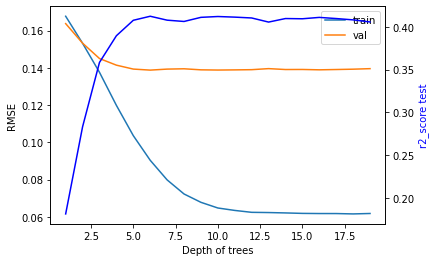

In [76]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

train_losses = []
test_losses = []
R2_lst = []
grid_search = range(1,20)

for depth in tqdm_notebook(grid_search):
    
    train_loss = 0
    test_loss = 0
    R2 = 0
    for i in range(10):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        X_train -= X_train.mean()
        X_train /= X_train.std()
        X_test -= X_test.mean()
        X_test /= X_test.std()

        regr = RandomForestRegressor(max_depth=depth, min_samples_split=15).fit(X_train,y_train)

        y_pred = pd.DataFrame(regr.predict(X_train))
        y_pred.index = X_train.index
        y_pred.columns = [feat]

        y_pred_t = pd.DataFrame(regr.predict(X_test))
        y_pred_t.index = X_test.index
        y_pred_t.columns = [feat]

        train_loss += np.sqrt(mean_squared_error(y_pred, y_train))
        test_loss += np.sqrt(mean_squared_error(y_pred_t, y_test))
        R2 += regr.score(X_test,y_test)


    train_losses.append(train_loss/10)
    test_losses.append(test_loss/10)
    R2_lst.append(R2/10)
       

fig, ax1 = plt.subplots()
ax1.set_xlabel('Depth of trees')
ax1.set_ylabel('RMSE')
ax1.plot(grid_search, train_losses, label='train')
ax1.plot(grid_search, test_losses, label='val')
ax1.legend()
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 
ax2.set_ylabel('r2_score test', c='b')  
ax2.plot(grid_search, R2_lst, c='b')
ax2.tick_params(axis='y')

In [77]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

pls2 = PLSRegression(n_components=1)
pls2.fit(X_train, y_train.values)
y_pred_test = pls2.predict(X_test)
print(np.sqrt(((y_pred_test[:,0] - y_test)**2).mean()))

0.1277876128607649


## Tools for figures

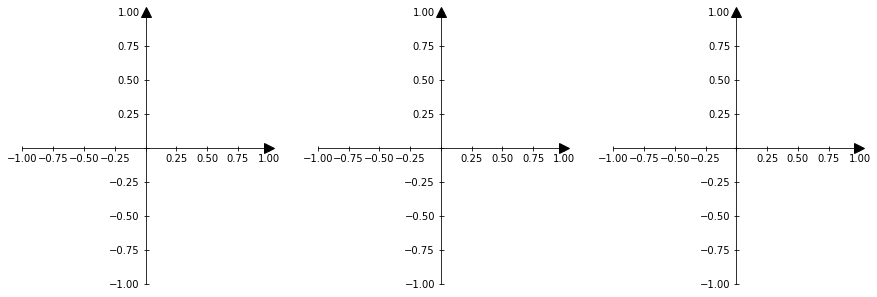

In [94]:
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : 5, "ytick.major.size" : 5,}
with plt.rc_context(rc):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    for i in range(3):
        ax[i].plot()

        ax[i].spines['left'].set_position('zero')
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_position('zero')
        ax[i].spines['top'].set_visible(False)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')

        # make arrows
        ax[i].plot((1), (0), ls="", marker=">", ms=10, color="k",
                transform=ax[i].get_yaxis_transform(), clip_on=False)
        ax[i].plot((0), (1), ls="", marker="^", ms=10, color="k",
                transform=ax[i].get_xaxis_transform(), clip_on=False)

        ax[i].yaxis.get_major_ticks()[4].label1.set_visible(False)
        ax[i].xaxis.get_major_ticks()[4].label1.set_visible(False)

        ax[i].set_xlim([-1, 1])
        ax[i].set_ylim([-1, 1])
    
    plt.show()

In [17]:
ax[i].yax[i]is.get_major_ticks()[1]

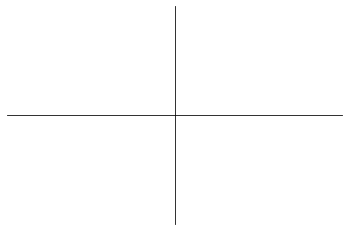

In [100]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xticks([])
plt.yticks([])

plt.plot()
plt.show()

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [26]:
data = torch.load('ADNI_small')

In [27]:
data = data['data']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])